# Extract timestamps from lidar point clouds to calculate offset vs Stereo collection date

In [1]:
import pdal
import json

In [2]:
# entwine_url = "http://usgs-lidar-public.s3.amazonaws.com/USGS_LPC_CO_MesaCo_QL2_2015_LAS_2017/ept.json"
# out_filename = "sample_dates_MesaCo_QL2_2015_LAS_2017.csv"
# entwine_url = "https://s3-us-west-2.amazonaws.com/usgs-lidar-public/USGS_LPC_WA_GlacierPeak_2014_LAS_2016/ept.json"
# out_filename = "sample_dates_USGS_LPC_WA_GlacierPeak_2014_LAS_2016.csv"
entwine_url = "https://s3-us-west-2.amazonaws.com/usgs-lidar-public/WY_FEMA_East_B9_2019/ept.json"
out_filename = "sample_dates_WY_FEMA_East_B9_2019.csv"
stereo_date = "2019-08-17"

resolution = 1000 # meters between points to sample
out_srs = "EPSG:32610"
pipeline = {
    "pipeline":
    [
     {"type": "readers.ept", "filename": entwine_url, "resolution": resolution},
     {"type": "filters.reprojection", "out_srs": out_srs},
     {"type": "writers.text", "format": "csv", "order": "X,Y,Z,GpsTime", "keep_unspecified": "false", "filename": out_filename}
    ]
}


In [3]:
pdal.pipeline.Pipeline(json=json.dumps(pipeline)).execute()

181721

## AstroPy converts GPSTime timestamps to UTC datetime

In [4]:
import astropy.time

def gpstime_to_utc(gpstime):

    """Convert GpsTime from LAZ files to UTC timestamps using AstroPy"""

    return astropy.time.Time(10**9 + float(gpstime), format="gps").datetime



In [6]:
import geopandas as gpd

In [7]:
gdf = gpd.read_file(out_filename, crs=out_srs)

In [8]:
def dates_gdf_from_df(df, crs, stereo_dt=None):
    """Load a pandas DF of X,Y,GpsTime rows & produce a GeoDataFrame with additional columns for UTCTime datetime object and other time fields"""
    gdf = gpd.GeoDataFrame(df, crs=crs, geometry=gpd.points_from_xy(df.X, df.Y))
    gdf["UTCTime"] = gdf["GpsTime"].apply(gpstime_to_utc)
    gdf["day_of_year"] = gdf["UTCTime"].dt.dayofyear
    gdf["time_since_first"] = gdf["UTCTime"] - gdf["UTCTime"].min() # for plotting
    gdf["days_since_first"] = gdf["time_since_first"].dt.days
    if stereo_dt:
        gdf["days_offset_from_stereo"] = (gdf["UTCTime"] - stereo_dt).dt.days
    return gdf

In [9]:
import datetime
stereo_dt = datetime.datetime.fromisoformat(stereo_date)
dates_gdf = dates_gdf_from_df(gdf, out_srs, stereo_dt=stereo_dt)

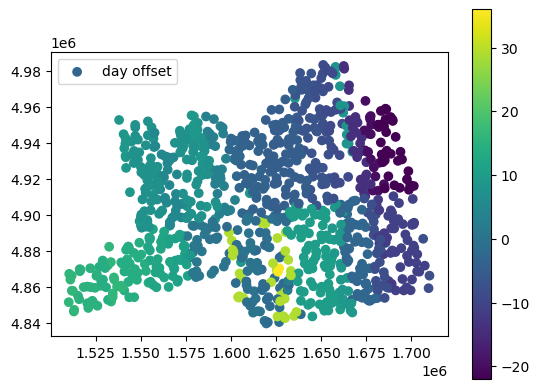

In [10]:
import matplotlib.pyplot as plt
dates_gdf.sample(1000).plot(column="days_offset_from_stereo", label="day offset", legend=True)
# plt.colorbar()
# Where is the 
plt.legend()

In [11]:
import contextily as ctx

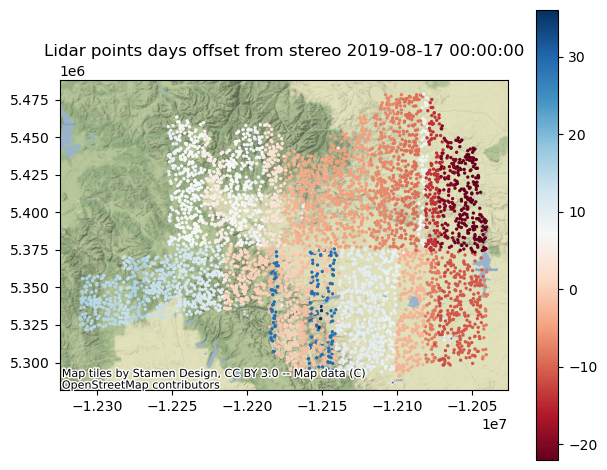

In [12]:
f, ax = plt.subplots()
#Convert points to web mercator projection and plot
dates_gdf.sample(5000).to_crs('EPSG:3857').plot(ax=ax, column='days_offset_from_stereo', cmap='RdBu', markersize=2, legend=True)
#Add basemap
ctx.add_basemap(ax=ax, source=ctx.providers.Stamen.Terrain)
plt.title(f"Lidar points days offset from stereo {stereo_dt}")
plt.tight_layout() # doesn't do everything I want

In [87]:
dates_gdf.head().explore(column="days_offset_from_stereo")

/mnt/1.0_TB_VOLUME/sethv/miniconda3/envs/der/lib/python3.10/site-packages/mapclassify/classifiers.py:891: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 - self.adcm / adam


TypeError: Object of type Timestamp is not JSON serializable

In [88]:
import folium
#location=wa_center_wgs84, 
stride=100
centroid = dates_gdf.to_crs('EPSG:4326').unary_union.centroid
map_center = (centroid.y, centroid.x)
m = folium.Map(location=map_center, zoom_start=10, tiles='Stamen Terrain')
# m.add_child(folium.features.GeoJson(dates_gdf.to_crs("EPSG:4326")[["geometry","days_offset_from_stereo"]][::stride].to_json()))
m